In [1]:
import h5py
import numpy
import numpy as np
import pandas as pd
import scipy.io, scipy.ndimage
import itertools


#Plotting
import ipympl
from matplotlib import pyplot as plt

#Paths & Files
import pickle as pkl
from pathlib import Path
import os

#Preprocessing/Split/Classifier
import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.discriminant_analysis as skda
import sklearn.preprocessing as skppc
import sklearn.pipeline as skppl
import sklearn.ensemble as skens
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.feature_selection as skfs

#Local scripts
from data import DecompData
from features import Raws, Means, Moup, Covariances, AutoCovariances
from plotting import graph_circle_plot, plots
from loading import load_task_data_as_pandas_df

#Progress Bar
from tqdm.notebook import tqdm

### Load/Extract session data

In [2]:
data_path = Path(os.path.abspath('')).parent / Path('data')
plot_path = Path(os.path.abspath('')).parent / Path('plots')


if (not (data_path/'extracted_data.pkl').exists()):
    # load behavior data
    sessions = load_task_data_as_pandas_df.extract_session_data_and_save(root_paths=[data_path], mouse_ids=["GN06"], reextract=False)
    with open( data_path / 'extracted_data.pkl', 'wb') as handle:
        pkl.dump(sessions, handle)
else:
    # load saved data
    with open( data_path / 'extracted_data.pkl', 'rb') as handle:
        sessions = pkl.load(handle)
    print("Loaded pickled data.")

file_path = data_path / "GN06" / Path('2021-01-20_10-15-16/SVD_data/Vc.mat')
f = h5py.File(file_path, 'r')

frameCnt = np.array(f['frameCnt'])
trial_starts = np.cumsum(frameCnt[:-1, 1])
svd = DecompData( sessions, np.array(f["Vc"]), np.array(f["U"]), np.array(trial_starts) )

Loaded pickled data.


In [3]:
#alignment
opts_path = data_path / "GN06" / Path('2021-01-20_10-15-16/SVD_data/opts.mat')

trans_params = scipy.io.loadmat(opts_path,simplify_cells=True)['opts']['transParams']
svd = DecompData( sessions, np.array(f["Vc"]), np.array(f["U"]), np.array(trial_starts), trans_params=trans_params)

-0.55266804
Min/Max Value: 0.0 0.9299964
Rotation
Min/Max Value: -2.3841858e-07 0.92942303
Scale/Zoom
Min/Max Value: -2.3841858e-07 0.8701406
Translate/Shift
Min/Max Value: -2.3841858e-07 0.5704692
crop


### Define Conditions & additional Filters

* Only select trials:
 * with full stimulation (svd.n_targets == 6) and no distractors (svd.n_distractors == 0)
 * out of training phase with no automatic reward (svd.auto_reward == 0) and both choices available (svd.both_spouts == 1)
 
 
* Define conditions as cross-product of:
 * modalities ['visual', 'tactile', 'vistact']
 * side ['right', 'left']

In [4]:
#filter for all conds
trial_preselection = ((svd.n_targets == 6) & (svd.n_distractors == 0) & (svd.auto_reward == 0) & (svd.both_spouts == 1))

#define different conds
modal_keys = ['visual', 'tactile', 'vistact']
modal_range = range(3)
side_keys = ['right', 'left']
side_range = range(2)

#set condition filter
cond_keys =  itertools.product(modal_keys,side_keys)
cond_keys_str = [f"{s}_{m}" for m, s in list(cond_keys)]

#apply filter
svd = svd[trial_preselection]
svd.conditions = [{"modality" : modal, "target_side_left" : side} for modal, side in itertools.product(modal_range,side_range)]

### Settings for parcellation and classification 

In [5]:
comp = 20 # Number componants to use
n_rep = 5  # Number of folds

#others
save_outputs = True
baseline_mode = None  #### basline mode ('mean' / 'zscore' / None)
n_comp_LDA = None #5  ### number of LDA componants (conds -1)

##RFE
RFE_edges = 189

### Feature calculation

In [6]:
feature_label = []
feature_data = {

    #"mean": [Means(svd.conditions[i,:,30:75],max_comps=comp) for i in range(len(svd.conditions))], #mean of stimulusframes for first cond
    #"mean(-base)": [Means(svd.conditions[i,:,30:75]-Means(svd.conditions[i,:,15:30]),comp) for i in range(len(svd.conditions))],
    #"raw": [Raws(svd.conditions[i,:,30:75],comp) for i in range(len(svd.conditions))], #mean of stimulusframes for first cond,
    
    "Cov w/o_Diagonal": [Covariances(svd.conditions[i,:,30:75],max_comps=comp, include_diagonal= False) for i in tqdm(range(len(svd.conditions)),desc='Conditions')], #mean of stimulusframes for first cond
    #"Cov w/Diagonal": [Covariances(svd.conditions[i,:,30:75],max_comps=comp, include_diagonal= True) for i in tqdm(range(len(svd.conditions)),desc='Conditions')],

}

features = list(feature_data.keys())
feature_label = features

lag = 2
for j in tqdm(range(0,lag,1),desc="Time-lags for Cov and MOU-Process"):
    feature_data["Cov(𝜏="+str(j)+")"] =[AutoCovariances(svd.conditions[i,:,30:75],max_comps=comp,time_lag_range=[j],label=cond_keys_str[i]) for i in tqdm(range(len(svd.conditions)),desc="Cov(𝜏="+str(j)+")")]   
    feature_label.append(r"Cov($\tau$="+str(j)+")")
    
    if j>0:        
        feature_data["Mou(𝜏="+str(j)+")"] = [Moup(svd.conditions[i,:,30:75],max_comps=comp,time_lag=j,label=cond_keys_str[i]) for i in tqdm(range(len(svd.conditions)),desc="Mou(𝜏="+str(j)+")")]
        feature_label.append(r"Mou($\tau$="+str(j)+")")

       

Conditions:   0%|          | 0/6 [00:00<?, ?it/s]

Time-lags for Cov and MOU-Process:   0%|          | 0/2 [00:00<?, ?it/s]

Cov(𝜏=0):   0%|          | 0/6 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

Cov(𝜏=1):   0%|          | 0/6 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

Mou(𝜏=1):   0%|          | 0/6 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

### k-folded Fitting & Scoring Classifiers 

Fit & score classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

Fit and Score Classifiers: 0it [00:00, ?it/s]

MLR 0.6338028169014085
[  0 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 119 118 117 116  96  97  98  99 100 101 102 103 104 139 105 107
 108 109 110 111 112 113 114 115 106 140 141 142 167 168 169 170 171 172
 173 174 175 166 176 178 179 180 181 182 183 184 185 186 177  95 165 163
 143 144 145 146 147 148 149 150 151 164 152 154 155 156 157 158 159 160
 161 162 153 187  94  92  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  24  23  22  21   1   2   3   4   5   6   7
   8   9  44  10  12  13  14  15  16  17  18  19  20  11  45  46  47  72
  73  74  75  76  77  78  79  80  71  81  83  84  85  86  87  88  89  90
  91  82  93  70  68  48  49  50  51  52  53  54  55  56  69  57  59  60
  61  62  63  64  65  66  67  58 188]
[  1 323 132  13 196 222 111  76 320 191 211  52 102 200 229  68 299 291
 219 202 151  94 277 175 154 266 259  65 344  32 149 354 188 279  34 159
   2 237 189 127 179 350 228 309 272 117  18 212 281 314 290 16

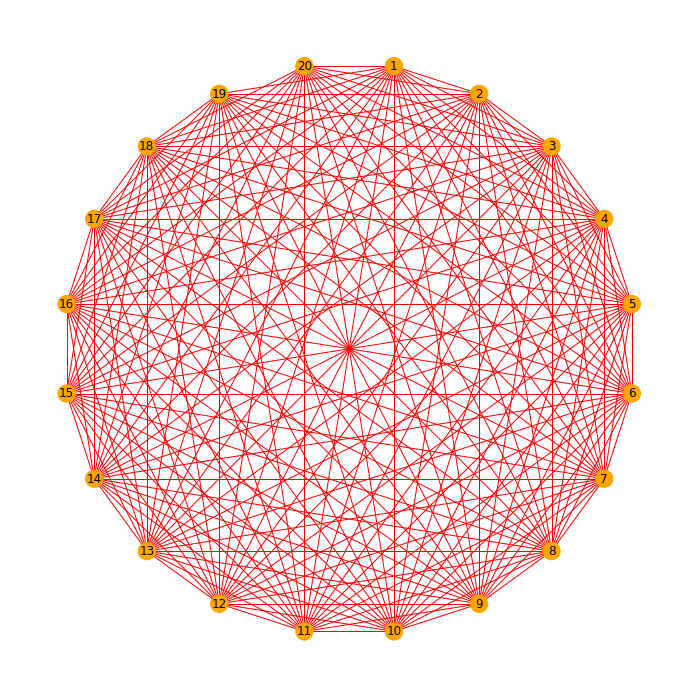

Fit and Score Classifiers: 0it [00:00, ?it/s]

MLR 0.6197183098591549
[  0 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 119 118 117 116  96  97  98  99 100 101 102 103 104 139 105 107
 108 109 110 111 112 113 114 115 106 140 141 142 167 168 169 170 171 172
 173 174 175 166 176 178 179 180 181 182 183 184 185 186 177  95 165 163
 143 144 145 146 147 148 149 150 151 164 152 154 155 156 157 158 159 160
 161 162 153 187  94  92  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  24  23  22  21   1   2   3   4   5   6   7
   8   9  44  10  12  13  14  15  16  17  18  19  20  11  45  46  47  72
  73  74  75  76  77  78  79  80  71  81  83  84  85  86  87  88  89  90
  91  82  93  70  68  48  49  50  51  52  53  54  55  56  69  57  59  60
  61  62  63  64  65  66  67  58 188]
[  1 323 132  13 196 222 111  76 320 191 211  52 102 200 229  68 299 291
 219 202 151  94 277 175 154 266 259  65 344  32 149 354 188 279  34 159
   2 237 189 127 179 350 228 309 272 117  18 212 281 314 290 16

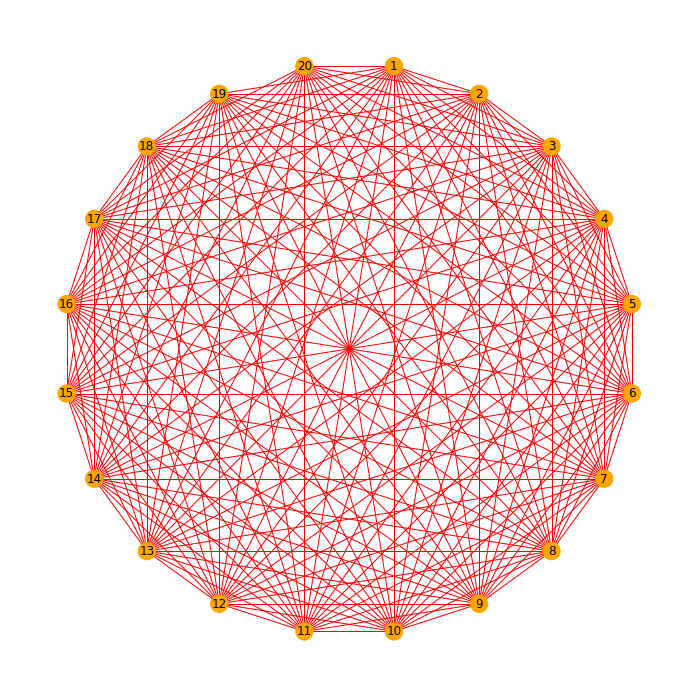

Fit and Score Classifiers: 0it [00:00, ?it/s]

MLR 0.6197183098591549
[  0 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 119 118 117 116  96  97  98  99 100 101 102 103 104 139 105 107
 108 109 110 111 112 113 114 115 106 140 141 142 167 168 169 170 171 172
 173 174 175 166 176 178 179 180 181 182 183 184 185 186 177  95 165 163
 143 144 145 146 147 148 149 150 151 164 152 154 155 156 157 158 159 160
 161 162 153 187  94  92  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  24  23  22  21   1   2   3   4   5   6   7
   8   9  44  10  12  13  14  15  16  17  18  19  20  11  45  46  47  72
  73  74  75  76  77  78  79  80  71  81  83  84  85  86  87  88  89  90
  91  82  93  70  68  48  49  50  51  52  53  54  55  56  69  57  59  60
  61  62  63  64  65  66  67  58 188]
[  1 323 132  13 196 222 111  76 320 191 211  52 102 200 229  68 299 291
 219 202 151  94 277 175 154 266 259  65 344  32 149 354 188 279  34 159
   2 237 189 127 179 350 228 309 272 117  18 212 281 314 290 16

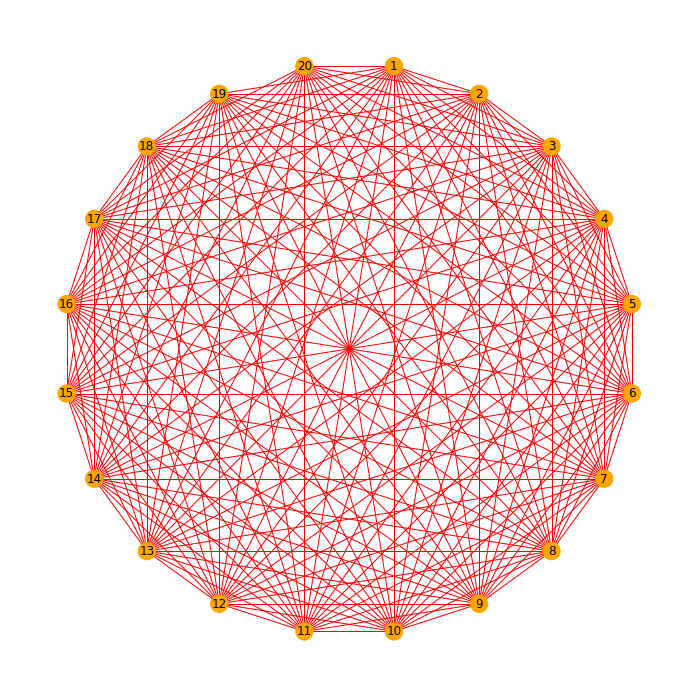

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

(44, 400)


left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

(45, 400)


right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

(76, 400)


left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

(83, 400)


right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

(51, 400)


left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

(56, 400)


right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

(44, 400)


left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

(45, 400)


right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

(76, 400)


left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

(83, 400)


right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

(51, 400)


left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

(56, 400)


Fit and Score Classifiers: 0it [00:00, ?it/s]

MLR 0.49295774647887325
[  0 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 119 118 117 116  96  97  98  99 100 101 102 103 104 139 105 107
 108 109 110 111 112 113 114 115 106 140 141 142 167 168 169 170 171 172
 173 174 175 166 176 178 179 180 181 182 183 184 185 186 177  95 165 163
 143 144 145 146 147 148 149 150 151 164 152 154 155 156 157 158 159 160
 161 162 153 187  94  92  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  24  23  22  21   1   2   3   4   5   6   7
   8   9  44  10  12  13  14  15  16  17  18  19  20  11  45  46  47  72
  73  74  75  76  77  78  79  80  71  81  83  84  85  86  87  88  89  90
  91  82  93  70  68  48  49  50  51  52  53  54  55  56  69  57  59  60
  61  62  63  64  65  66  67  58 188]
[  1 323 132  13 196 222 111  76 320 191 211  52 102 200 229  68 299 291
 219 202 151  94 277 175 154 266 259  65 344  32 149 354 188 279  34 159
   2 237 189 127 179 350 228 309 272 117  18 212 281 314 290 1

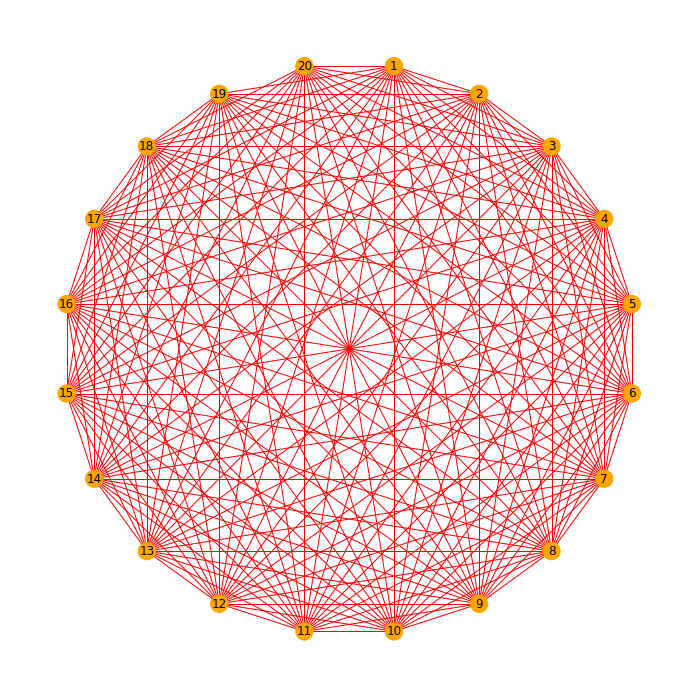

In [7]:
cv = StratifiedShuffleSplit(n_rep, test_size=0.2, random_state=420)
perf = np.zeros([n_rep, len(feature_data), 5])
classifiers = {}

for i_feat, feat in enumerate(tqdm(feature_data.keys(),desc="Fit & score classifiers",position=0)):
  
    data = np.concatenate([f.flatten() for f in feature_data[feat]])
    labels = np.concatenate( [np.full((len(feature_data[feat][i].flatten())),cond_keys_str[i])
                                for i in range(len(feature_data[feat]))] )
    #feature_labels[feat]
    #for i in range(len(feature_data[feat])):
         #= feature_data[feat][i]
    
    


    scaler = preprocessing.StandardScaler().fit( data )
    data = scaler.transform(data)

    cv_split = cv.split(data, labels)
    
    ##RFE
    rk_inter = np.zeros([n_rep,RFE_edges],dtype=np.int)
    

    c_MLR = skppl.make_pipeline(skppc.StandardScaler(),
                                skllm.LogisticRegression(C=1, penalty='l2', multi_class='multinomial',
                                                         solver='lbfgs',
                                                         max_iter=500))
    
    RFE_inter = skfs.RFE(c_MLR,n_features_to_select=int(RFE_edges))
    
    c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')

    c_LDA = skda.LinearDiscriminantAnalysis(n_components=n_comp_LDA, solver='eigen', shrinkage='auto')

    c_RF = skens.RandomForestClassifier(n_estimators=100, bootstrap=False)

    classifiers[feat]={"c_MLR":c_MLR.get_params()['steps'][1][1],"c_1NN":c_1NN,"c_LDA":c_LDA,"c_RF":c_RF}

    i = 0  ## counter
    for train_idx, test_idx in tqdm(cv_split,desc='Fit and Score Classifiers'):
        #print(f'\tRepetition {i:>3}/{n_rep}', end="\r" )
        c_MLR.fit(data[train_idx, :], labels[train_idx])
        c_1NN.fit(data[train_idx, :], labels[train_idx])
        c_LDA.fit(data[train_idx, :], labels[train_idx])
        c_RF .fit(data[train_idx, :], labels[train_idx])

        list_best_feat = np.argsort(rk_inter.mean(0))[:RFE_edges]
        RFE_inter.fit(data[train_idx, :][:,list_best_feat], labels[train_idx])


        perf[i, i_feat, 0] = c_MLR.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 1] = c_1NN.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 2] = c_LDA.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 3] = c_RF.score(data[test_idx, :], labels[test_idx])

        print("MLR",perf[i, i_feat, 0])

        print(list_best_feat)
        print(test_idx)
        print(data[test_idx, :][:,list_best_feat].shape)
        perf[i, i_feat, 4] = RFE_inter.estimator_.score(data[test_idx, :][:,list_best_feat], labels[test_idx])
        print("RFE MLR",perf[i, i_feat, 0])

        rk_inter[i,:] = RFE_inter.ranking_

        i += 1
        
    graph_circle_plot(rk_inter,n_nodes= comp,n_edges=RFE_edges, title=feature_label[i_feat])

### Plotting

Plotting Features:   0%|          | 0/4 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

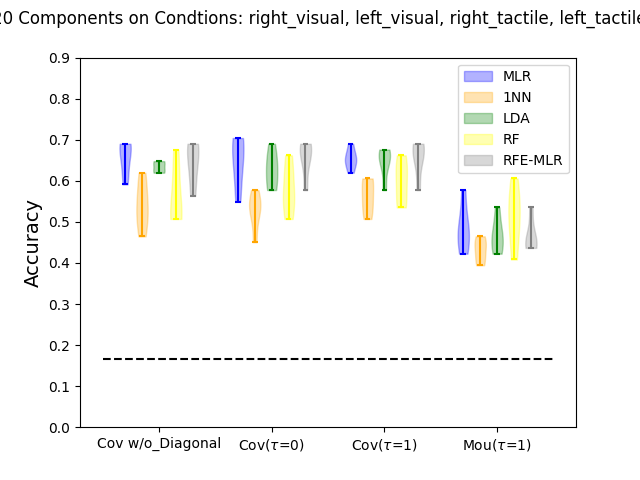

In [9]:
%matplotlib widget

if save_outputs:
    np.save('perf_tasks.npy', perf)
plt.figure()
title = ' '.join(["Classifiers Accuracies","for",str(comp),"Components on Condtions:",', '.join(cond_keys_str)]) #str(len(svd.conditions)),"Conditions"])
plt.suptitle(title)


for i, feat in enumerate(tqdm(feature_data,desc="Plotting Features")):
    v1 = plots.colored_violinplot(perf[:, i, 0], positions=np.arange(1) + i - 0.3, widths=[0.1], color="blue")
    v2 = plots.colored_violinplot(perf[:, i, 1], positions=np.arange(1) + i - 0.15, widths=[0.1], color="orange")
    v3 = plots.colored_violinplot(perf[:, i, 2], positions=np.arange(1) + i + 0, widths=[0.1], color="green")
    v4 = plots.colored_violinplot(perf[:, i, 3], positions=np.arange(1) + i + 0.15, widths=[0.1], color="yellow")
    v5 = plots.colored_violinplot(perf[:, i, 4], positions=np.arange(1) + i + 0.3, widths=[0.1], color="grey")
    if i == 0:
        plt.legend( [ v['bodies'][0] for v in [v1,v2,v3,v4,v5]], [ "MLR", "1NN", "LDA","RF","RFE-MLR" ] )

if (not feature_label):
    feature_label = feature_data.keys()

plt.xticks(range(len(feature_label)), [ feat for feat in feature_label ])
plt.plot([-.5, len(feature_label)-.5], [1/len(svd.conditions), 1/len(svd.conditions)], '--k')
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel('Accuracy', fontsize=14)

plt.savefig( plot_path/(title+".png") )
plt.show